In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt




In [2]:
df = pd.read_csv('GlobalLandTemperaturesByState.csv')

In [3]:
df.columns = ['dt', 'average_temperature', 'average_temperature_uncertainty', 'state', 'country']

In [4]:
df = df[df.state == 'Texas' ]

In [5]:
df.head()

,dt,average_temperature,average_temperature_uncertainty,state,country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [6]:
df.dt = pd.to_datetime(df.dt)

In [7]:
df.set_index('dt', inplace=True)

In [8]:
df['year'] = df.index.year
df['month'] = df.index.month

In [9]:
df['u_pos'] = df.average_temperature + df.average_temperature_uncertainty
df['u_neg'] = df.average_temperature - df.average_temperature_uncertainty

In [10]:
df.head()

,average_temperature,average_temperature_uncertainty,state,country,year,month,u_pos,u_neg
dt,,,,,,,,
1820-01-01,4.489,3.369,Texas,United States,1820,1,7.858,1.120
1820-02-01,9.081,2.873,Texas,United States,1820,2,11.954,6.208
1820-03-01,12.657,2.423,Texas,United States,1820,3,15.080,10.234
1820-04-01,19.215,2.501,Texas,United States,1820,4,21.716,16.714
1820-05-01,22.577,2.495,Texas,United States,1820,5,25.072,20.082


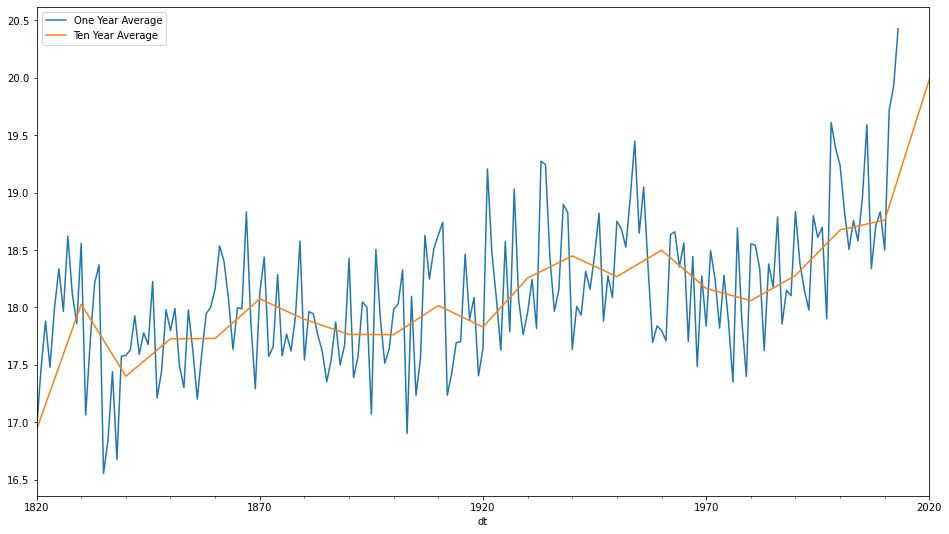

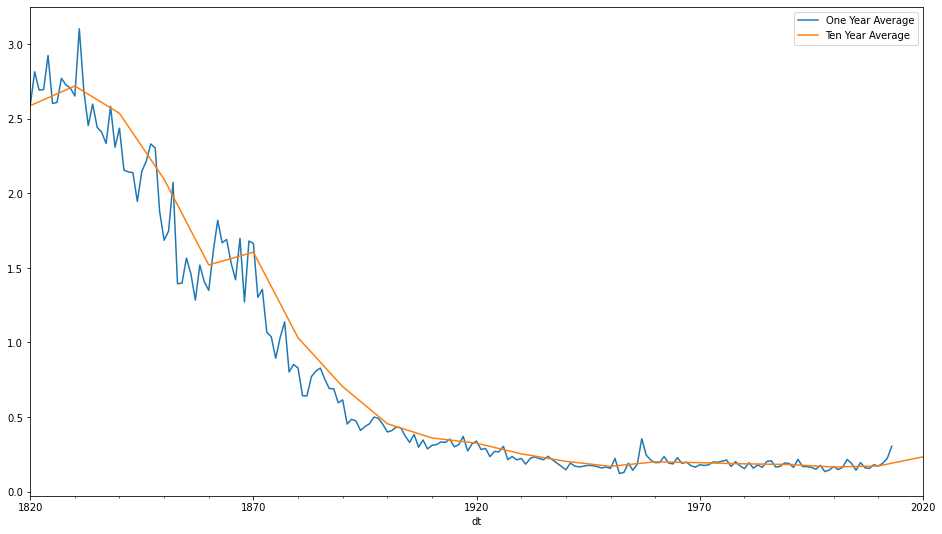

In [11]:
plt.figure(figsize=(16,9))

df.resample('Y').average_temperature.mean().plot(label='One Year Average')
# df.resample('5Y').average_temperature.mean().plot(label='Five Year Average')
df.resample('10Y').average_temperature.mean().plot(label='Ten Year Average')
plt.legend()
plt.show()

plt.figure(figsize=(16,9))
df.resample('Y').average_temperature_uncertainty.mean().plot(label='One Year Average')
# df.resample('5Y').average_temperature_uncertainty.mean().plot(label='Five Year Average')
df.resample('10Y').average_temperature_uncertainty.mean().plot(label='Ten Year Average')
plt.legend()
plt.show()


# **Uncertainty**

![](https://sisu.ut.ee/sites/default/files/styles/os_files_xxlarge/public/measurement/files/1-1c.png?itok=_w6fni9o)

## - average temperature uncertainty is the 95% confidence interval around the average

# Let's visualize this 

<AxesSubplot:xlabel='dt'>

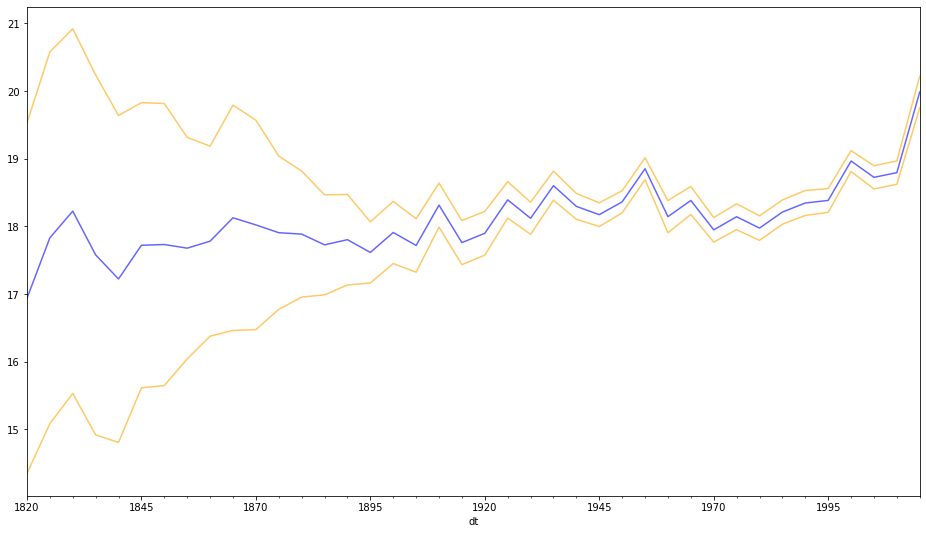

In [12]:
plt.figure(figsize=(16,9))
df.resample('5Y').u_pos.mean().plot(label='Max Possible Temp Average', c='orange', alpha=0.6)
df.resample('5Y').u_neg.mean().plot(label='Min Possible Temp Average', c='orange', alpha=0.6)
df.resample('5Y').average_temperature.mean().plot(label='Ten Year Average', c='blue', alpha=0.6)

<AxesSubplot:xlabel='dt', ylabel='average_temperature'>

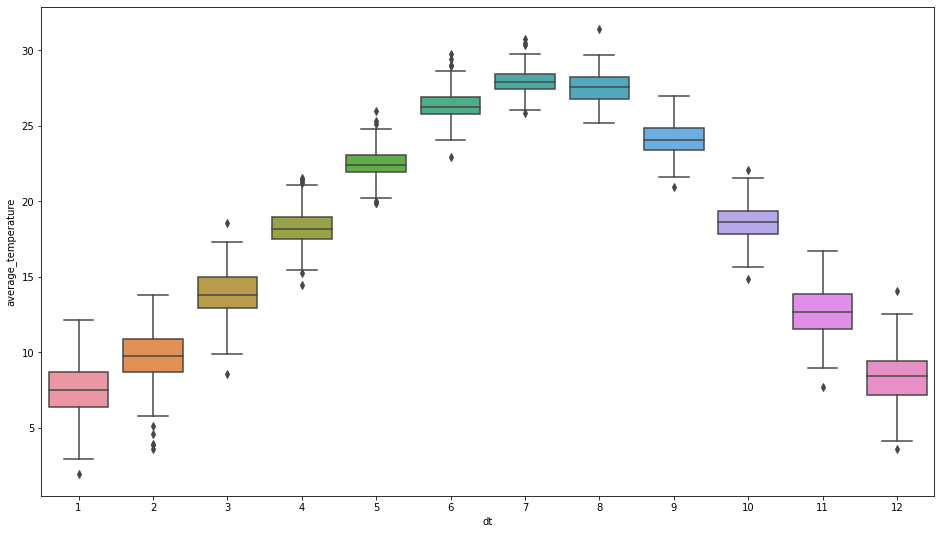

In [13]:
plt.figure(figsize=(16,9))
sns.boxplot(data = df, x = df.index.month, y = 'average_temperature')

### I will drop records before year 1895 due to high level of variance

In [14]:
df = df[df['year'] >= 1895]

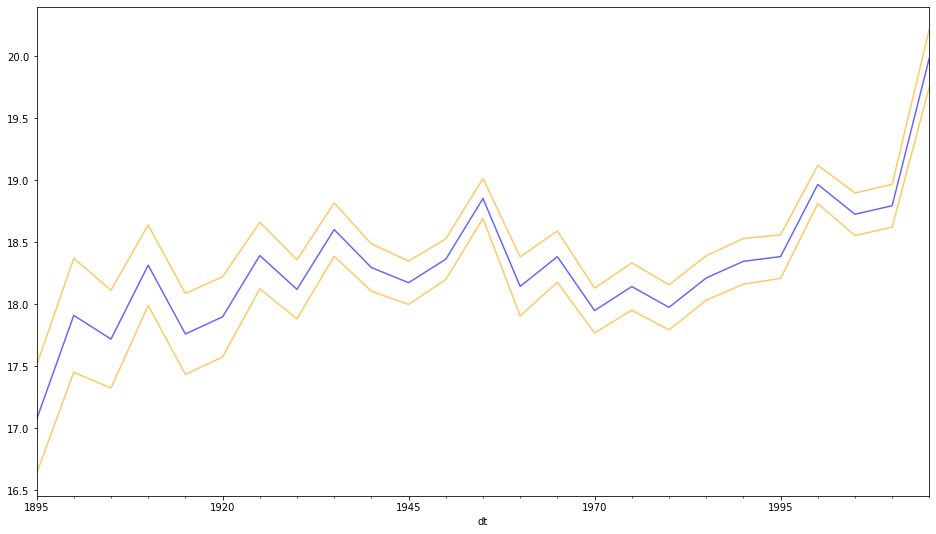

In [15]:
plt.figure(figsize=(16,9))
df.resample('5Y').u_pos.mean().plot(label='Max Possible Temp Average', c='orange', alpha=0.6)
df.resample('5Y').u_neg.mean().plot(label='Min Possible Temp Average', c='orange', alpha=0.6)
df.resample('5Y').average_temperature.mean().plot(label='Ten Year Average', c='blue', alpha=0.6)
plt.show()

## There seems to be greater temperature variance in the winter months

# Split Data

In [16]:
df.columns

Index(['average_temperature', 'average_temperature_uncertainty', 'state',
       'country', 'year', 'month', 'u_pos', 'u_neg'],
      dtype='object')

In [17]:
dropcols=['average_temperature_uncertainty', 'state',
       'country', 'year', 'month', 'u_pos', 'u_neg']

In [18]:
df.drop(columns=dropcols, inplace=True)

In [19]:
train_size = int(len(df) * .7)
train_size

997

In [20]:
validate_size = int(len(df) * .2)
validate_size

285

In [21]:
test_size = int(len(df) - train_size - validate_size)
test_size

143

In [22]:
# validate will go from 912 to 912+547
validate_end_index = train_size + validate_size
validate_end_index

1282

In [23]:
# train will go from 
train = df[: train_size]
# validate will go from 
validate = df[train_size:validate_end_index]
# test will include ### to the end
test = df[validate_end_index:]

In [24]:
train.shape, validate.shape, test.shape

((997, 1), (285, 1), (143, 1))

In [25]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [26]:
print(df.head(1) == train.head(1))

            average_temperature
dt                             
1895-01-01                 True


In [27]:
pd.concat([train.tail(1), validate.head(1)])

,average_temperature
dt,
1978-01-01,3.769
1978-02-01,5.141


In [28]:
pd.concat([validate.tail(1), test.head(1)])

,average_temperature
dt,
2001-10-01,18.679
2001-11-01,15.033


In [29]:
pd.concat([test.tail(1), df.tail(1)])

,average_temperature
dt,
2013-09-01,26.408
2013-09-01,26.408


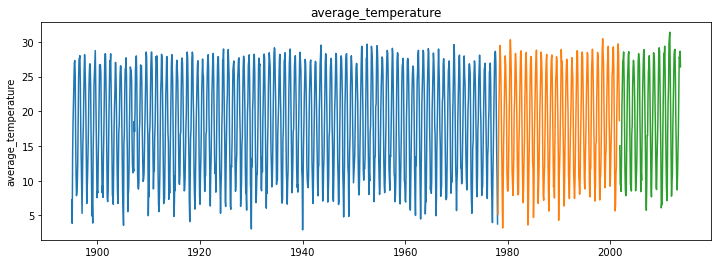

In [30]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Modeling

In [31]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [32]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [38]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


## 1. Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Average Temperature

In [33]:
avg_temp = round(train['average_temperature'][-1:][0], 2)
avg_temp

3.77

In [34]:
yhat_df = pd.DataFrame({'average_temperature': [avg_temp]}, 
                      index = validate.index)

yhat_df.head()

,average_temperature
dt,
1978-02-01,3.77
1978-03-01,3.77
1978-04-01,3.77
1978-05-01,3.77
1978-06-01,3.77


average_temperature -- RMSE: 17


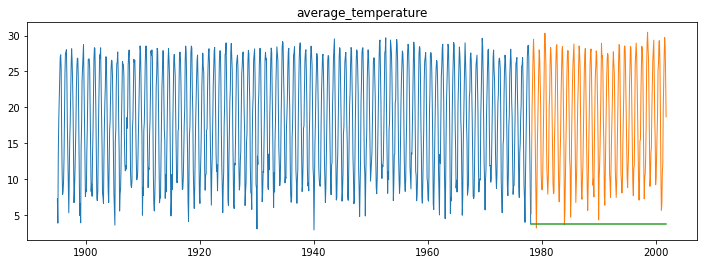

In [35]:
plot_and_eval('average_temperature')

In [40]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,17.0


## 2. Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [41]:
avg_temp = round(train['average_temperature'].mean(),2)
avg_temp

18.16

In [42]:
def make_predictions():
    yhat_df = pd.DataFrame({'average_temperature': [avg_temp]}, 
                           index = validate.index)
    return yhat_df

In [43]:
yhat_df = make_predictions()

In [44]:
yhat_df

,average_temperature
dt,
1978-02-01,18.16
1978-03-01,18.16
1978-04-01,18.16
1978-05-01,18.16
1978-06-01,18.16
...,...
2001-06-01,18.16
2001-07-01,18.16
2001-08-01,18.16


average_temperature -- RMSE: 7


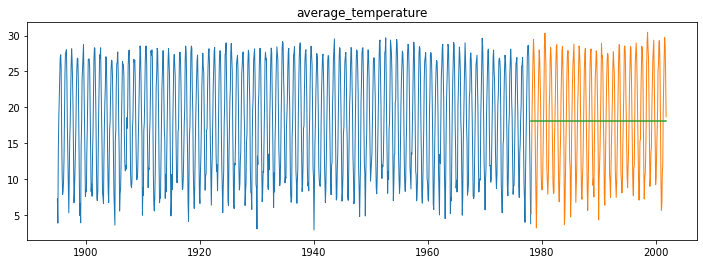

In [45]:
for col in train.columns:
    plot_and_eval(col)

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,17.0
1,simple_average,average_temperature,7.0


## 3. Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

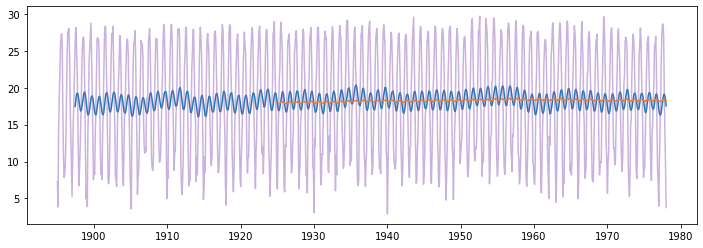

In [60]:
# train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['average_temperature'].rolling(30).mean())
plt.plot(train['average_temperature'].rolling(365).mean())
plt.plot(train['average_temperature'].rolling(1825).mean())
plt.plot(train['average_temperature'].rolling(3650).mean())
plt.plot(train['average_temperature'], alpha=.5)

In [61]:
# demonstrate that the mean of the first Year days 
# is equal to rolling(365) on day 365

print(train['average_temperature'].rolling(365).mean()[364])
print(train['average_temperature'].head(365).mean())

17.91804109589042
17.91804109589042


In [62]:
period = 365 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
avg_temp = round(train['average_temperature'].rolling(period).mean()[-1], 2)

print(avg_temp)

18.23


In [63]:
yhat_df = make_predictions()
yhat_df.head()

,average_temperature
dt,
1978-02-01,18.23
1978-03-01,18.23
1978-04-01,18.23
1978-05-01,18.23
1978-06-01,18.23


average_temperature -- RMSE: 7


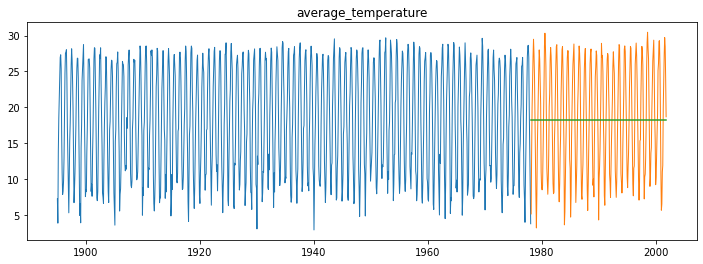

In [64]:
for col in train.columns:
    plot_and_eval(col)

In [71]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '1Y_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,17.0
1,simple_average,average_temperature,7.0
2,1Y_moving_avg,average_temperature,7.0


## 4. Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

average_temperature 



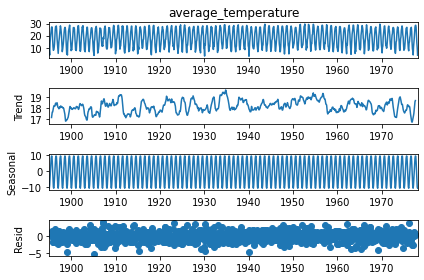

In [106]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [99]:
train.describe()

,average_temperature
count,997.000000
mean,18.156568
std,7.395979
min,2.908000
25%,11.270000
50%,18.427000
75%,25.374000
max,29.684000


In [103]:
col = 'average_temperature'
# create the Hold object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

<ipython-input-103-adf63d21257c>:3: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train[col], exponential=False, damped=True)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [104]:
yhat_df

,average_temperature
dt,
1978-02-01,-0.55
1978-03-01,-4.17
1978-04-01,-7.06
1978-05-01,-9.37
1978-06-01,-11.23
...,...
2001-06-01,-18.63
2001-07-01,-18.63
2001-08-01,-18.63


average_temperature -- RMSE: 38


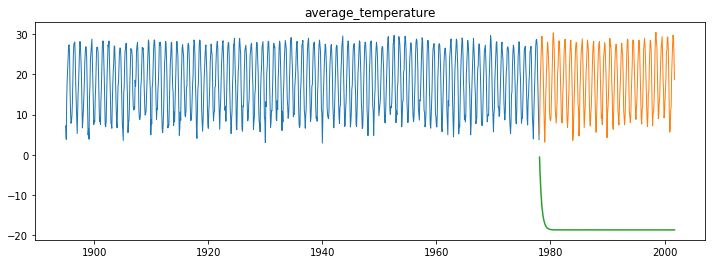

In [105]:
for col in train.columns:
    plot_and_eval(target_var = col)

### Not sure how this model messed up
#### - probably not the best model because years are not "seasonal"


## 5. Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [114]:
df.index.max()

Timestamp('2013-09-01 00:00:00')

In [125]:
train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1392, 1)
(12, 1)
(12, 1)


,average_temperature
dt,
2010-08-01,29.393
2010-09-01,25.612
2010-10-01,19.645
2010-11-01,13.821
2010-12-01,9.478


In [126]:
validate.tail(1), test.head(1)

(            average_temperature
 dt                             
 2011-12-01                7.774,
             average_temperature
 dt                             
 2012-01-01               10.127)

In [128]:
# finding the year-over-year difference for each day from 2010 to 2012
# taking the mean, and then adding that value to the daily 2012 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 

yhat_df = train['2010'] + train.diff(365).mean()

In [137]:
# train['2015']
float(train.average_temperature[train.index=='2010-12-01']) - float(train.average_temperature[train.index=='2009-12-01'])
# train.diff(365)

3.388

In [138]:
train.diff(365)[train.index>='2009-01-01'].mean()

average_temperature    0.731125
dtype: float64

In [139]:
train.loc['2010'].head()

,average_temperature
dt,
2010-01-01,6.748
2010-02-01,6.609
2010-03-01,12.741
2010-04-01,18.457
2010-05-01,23.408


In [140]:
yhat_df.head()

,average_temperature
dt,
2010-01-01,6.980499
2010-02-01,6.841499
2010-03-01,12.973499
2010-04-01,18.689499
2010-05-01,23.640499


In [141]:
# set yhat_df to index of validate

yhat_df.index = validate.index
yhat_df

,average_temperature
dt,
2011-01-01,6.980499
2011-02-01,6.841499
2011-03-01,12.973499
2011-04-01,18.689499
2011-05-01,23.640499
2011-06-01,28.594499
2011-07-01,27.941499
2011-08-01,29.625499
2011-09-01,25.844499


average_temperature -- RMSE: 2


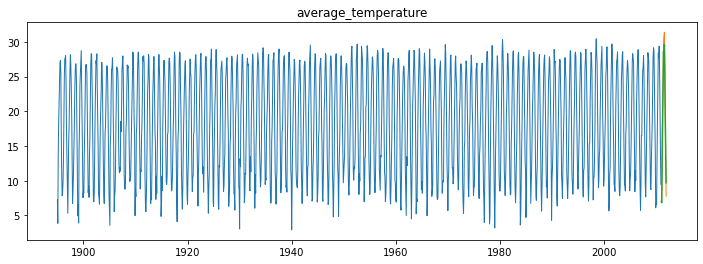

In [142]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [143]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'previous_year', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temperature,17.0
1,simple_average,average_temperature,7.0
2,1Y_moving_avg,average_temperature,7.0
3,30d_moving_avg,average_temperature,8.0
4,90d_moving_avg,average_temperature,7.0
5,180d_moving_avg,average_temperature,7.0
6,previous_year,average_temperature,2.0
7,previous_year,average_temperature,2.0


# Conclusion